In [1]:
# Step 1: Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from IPython.display import display

In [2]:
# Step 2: Load the dataset
cali_housing = fetch_california_housing(as_frame=True)
data = cali_housing.frame

In [111]:
class DataProcessor:
    def __init__(self, data):
        self.data = data
        self.initial_features = data.columns.tolist()
        self.dropped_features = []

    def clean_outliers(self, columns):
        z_scores = np.abs(
            zscore(self.data[columns])
        )  # Compute z-scores for specified columns
        filtered_entries = (z_scores < 3).any(
            axis=1
        )  # Filter out rows with any z-score >= 3
        self.data = self.data[filtered_entries]  # Update the dataframe
        return self.data

    def remove_highly_correlated_feature(self, target, threshold=0.9):
        corr_matrix = self.data.corr().abs()  # Compute correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Select upper triangle of correlation matrix
        to_drop = []  # List to track which features to drop
        target_corr = self.data.corr()[target].abs()  # Correlation with the target

        for column in upper.columns:
            correlated_features = upper.index[upper[column] > threshold].tolist()
            if correlated_features:
                # Determine the feature with the lower correlation with the target
                to_remove = correlated_features[0] if target_corr[correlated_features[0]] < target_corr[column] else column
                if to_remove not in to_drop:
                    to_drop.append(to_remove)

        # Drop the selected features
        self.dropped_features = to_drop
        self.data = self.data.drop(to_drop, axis=1)
        print(f"Dropped features due to high correlation (threshold={threshold}): {to_drop}")
        return self.data

    def split_data(self, target, test_size=0.2, random_state=42):
        X = self.data.drop(columns=[target])  # Features
        y = self.data[target]  # Target variable
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [98]:
# Step 4: Define Visualization class
class DataVisualizer:
    @staticmethod
    def display_dataframe(df):
        display(df)

    @staticmethod
    def visualize_correlations(df):
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
        plt.title("Correlation Matrix")
        plt.show()

    @staticmethod
    def visualize_distributions(df, columns):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        sns.histplot(df[columns[0]], ax=axes[0, 0], kde=True)
        sns.histplot(df[columns[1]], ax=axes[0, 1], kde=True)
        sns.histplot(df[columns[2]], ax=axes[1, 0], kde=True)
        sns.histplot(df[columns[3]], ax=axes[1, 1], kde=True)
        axes[0, 0].set_title(f"{columns[0]} Distribution")
        axes[0, 1].set_title(f"{columns[1]} Distribution")
        axes[1, 0].set_title(f"{columns[2]} Distribution")
        axes[1, 1].set_title(f"{columns[3]} Distribution")
        plt.tight_layout()
        plt.show()

In [99]:
# Step 5: Define ModelManager class
class ModelManager:
    def __init__(self, pipeline, param_grid=None):
        self.pipeline = pipeline
        self.param_grid = param_grid

    def train(self, X_train, y_train):
        if self.param_grid:
            grid_search = GridSearchCV(
                self.pipeline, self.param_grid, cv=5, scoring="r2", n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            self.pipeline = grid_search.best_estimator_
            self.best_params_ = grid_search.best_params_
        else:
            self.pipeline.fit(X_train, y_train)
        return self.pipeline

    def evaluate(self, X_test, y_test):
        y_pred = self.pipeline.predict(X_test)
        r2 = self.pipeline.score(X_test, y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        return r2, mae, mape

    def get_best_params(self):
        if self.param_grid:
            return self.best_params_
        return None

In [100]:
# Step 6: Define ResultDisplay class
class ResultDisplay:
    @staticmethod
    def display_metrics(r2, mae, mape):
        metrics_df = pd.DataFrame({
            'R2': [r2],
            'MAE': [mae],
            'MAPE': [mape]
        })
        display(metrics_df)

    @staticmethod
    def compare_metrics(previous_metrics, new_metrics):
        comparison_df = pd.DataFrame({
            'Metric': ['R2', 'MAE', 'MAPE'],
            'Previous': previous_metrics,
            'New': new_metrics
        })
        display(comparison_df)
        
        if (new_metrics[0] > previous_metrics[0]) and (new_metrics[1] < previous_metrics[1]) and (new_metrics[2] < previous_metrics[2]):
            print("The new model has improved performance.")
        else:
            print("The new model did not improve performance.")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


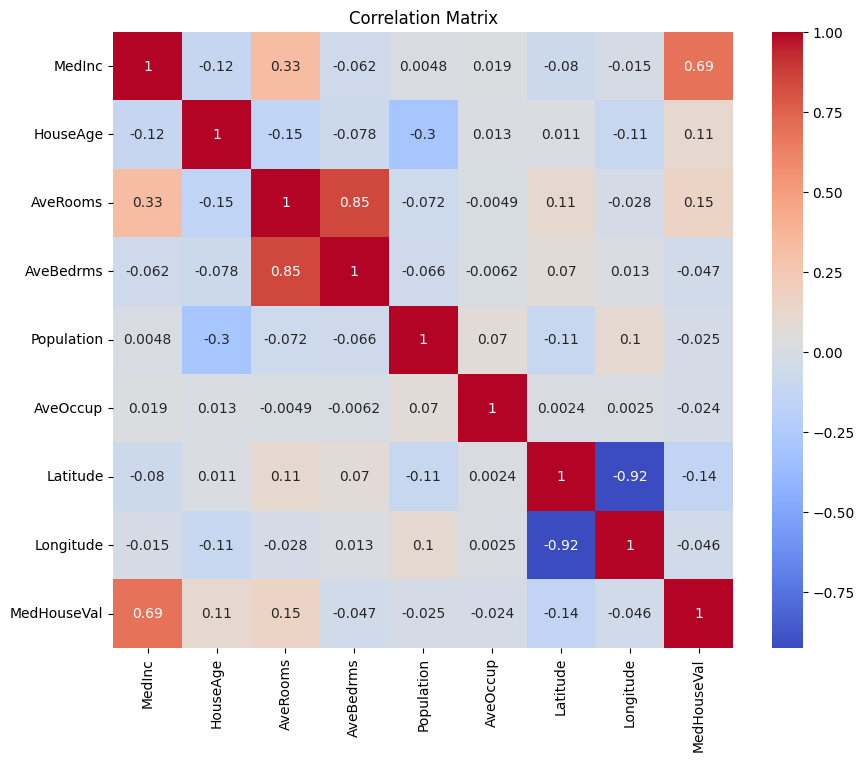

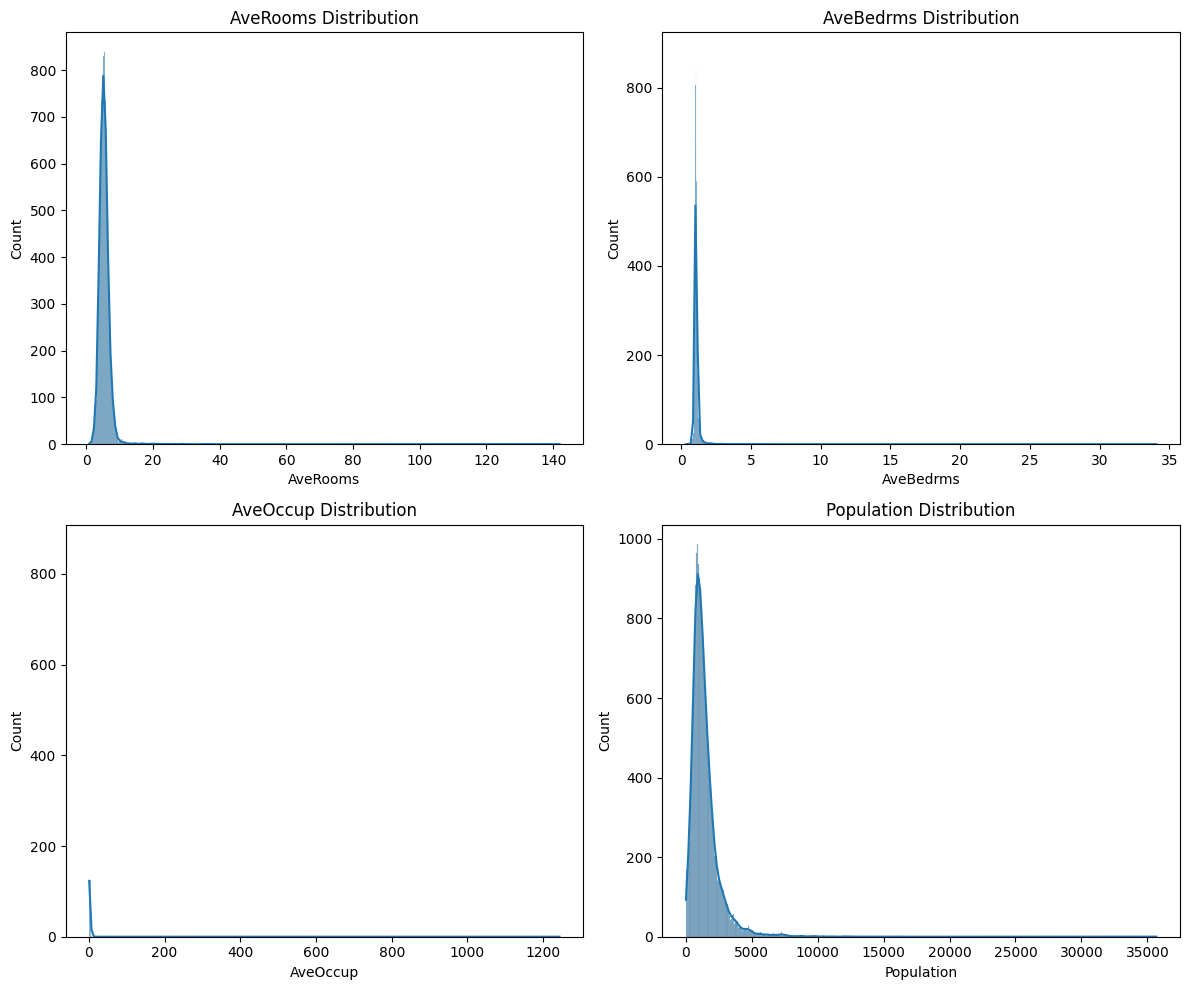

In [112]:
# Step 7: Visualize raw data
DataVisualizer.display_dataframe(data)
DataVisualizer.visualize_correlations(data)
DataVisualizer.visualize_distributions(
    data, ["AveRooms", "AveBedrms", "AveOccup", "Population"]
)

In [113]:
# Step 8: Instantiate DataProcessor and process the data
processor = DataProcessor(data)
data_clean = processor.clean_outliers(
    ["AveRooms", "AveBedrms", "AveOccup", "Population"]
)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


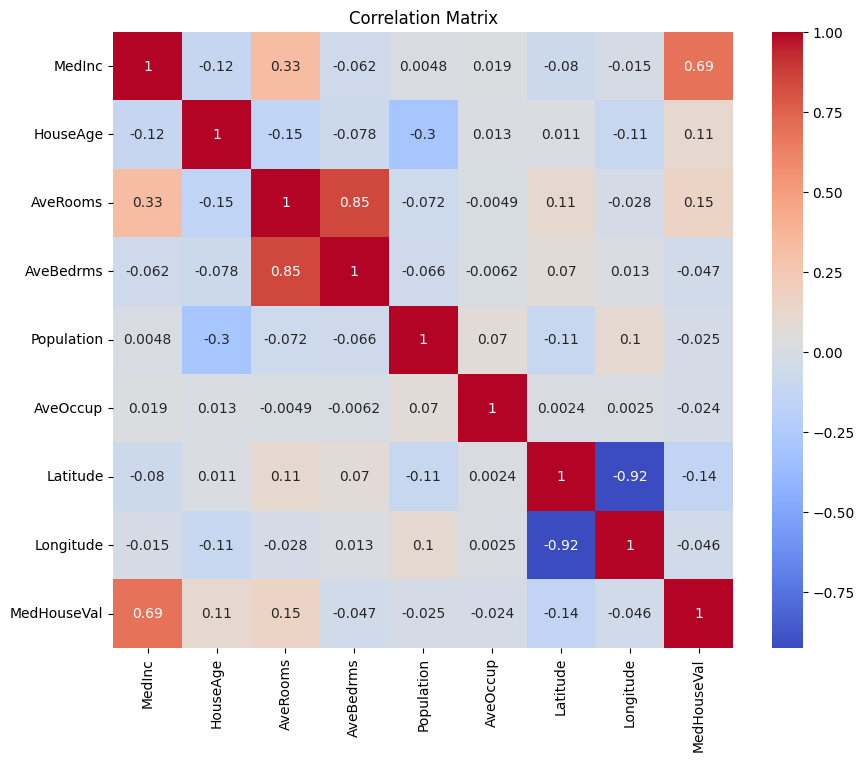

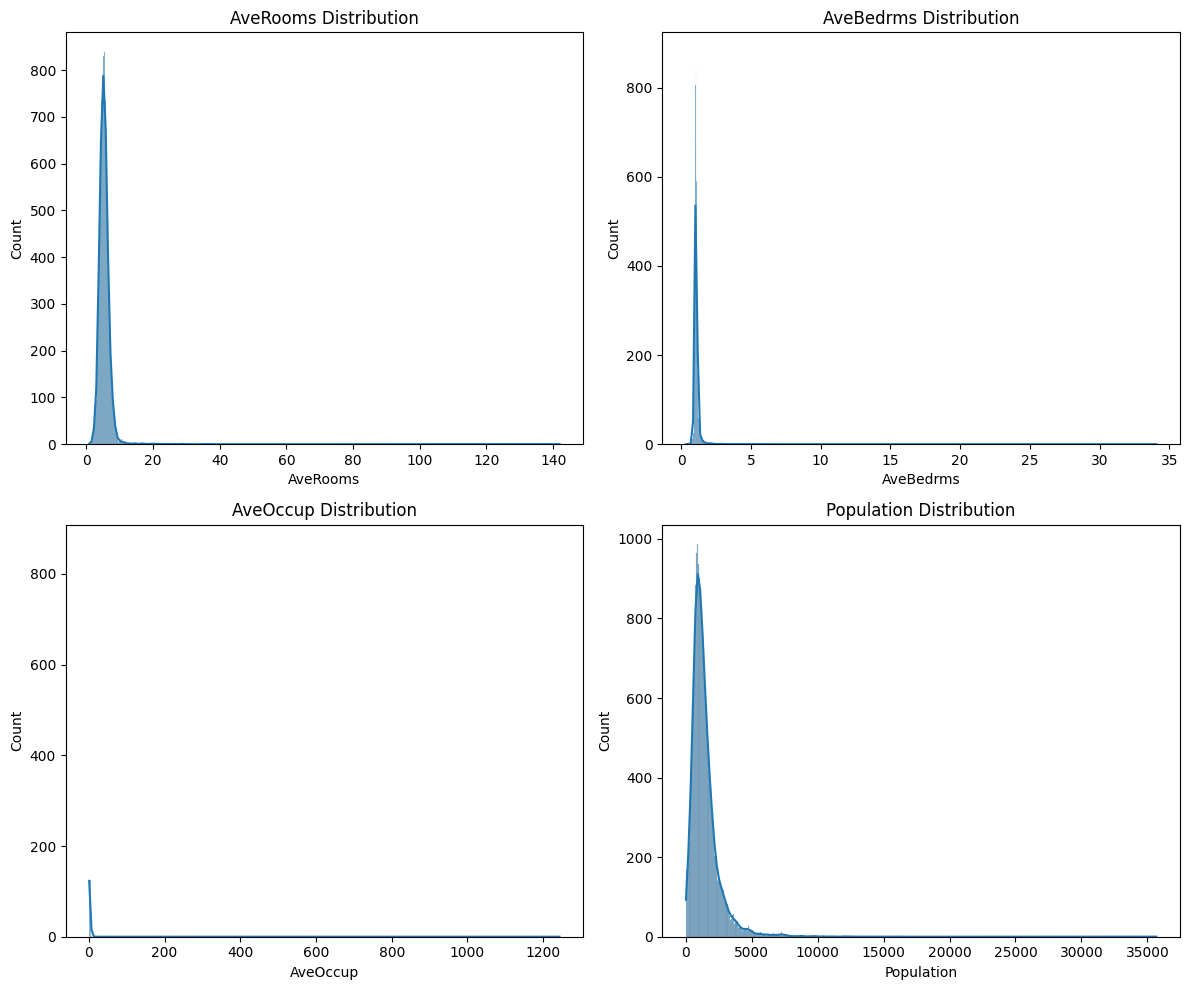

In [114]:
# Step 9: Display and visualize data
DataVisualizer.display_dataframe(data_clean)
DataVisualizer.visualize_correlations(data_clean)
DataVisualizer.visualize_distributions(
    data_clean, ["AveRooms", "AveBedrms", "AveOccup", "Population"]
)

In [115]:
# Step 10: Remove highly correlated features
data_clean = processor.remove_highly_correlated_feature(
    target="MedHouseVal", threshold=0.8
)

Dropped features due to high correlation (threshold=0.8): ['AveBedrms', 'Longitude']


,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,MedHouseVal
0,8.3252,41.0,6.984127,322.0,2.555556,37.88,4.526
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86,3.585
2,7.2574,52.0,8.288136,496.0,2.802260,37.85,3.521
3,5.6431,52.0,5.817352,558.0,2.547945,37.85,3.413
4,3.8462,52.0,6.281853,565.0,2.181467,37.85,3.422
...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,845.0,2.560606,39.48,0.781
20636,2.5568,18.0,6.114035,356.0,3.122807,39.49,0.771
20637,1.7000,17.0,5.205543,1007.0,2.325635,39.43,0.923
20638,1.8672,18.0,5.329513,741.0,2.123209,39.43,0.847


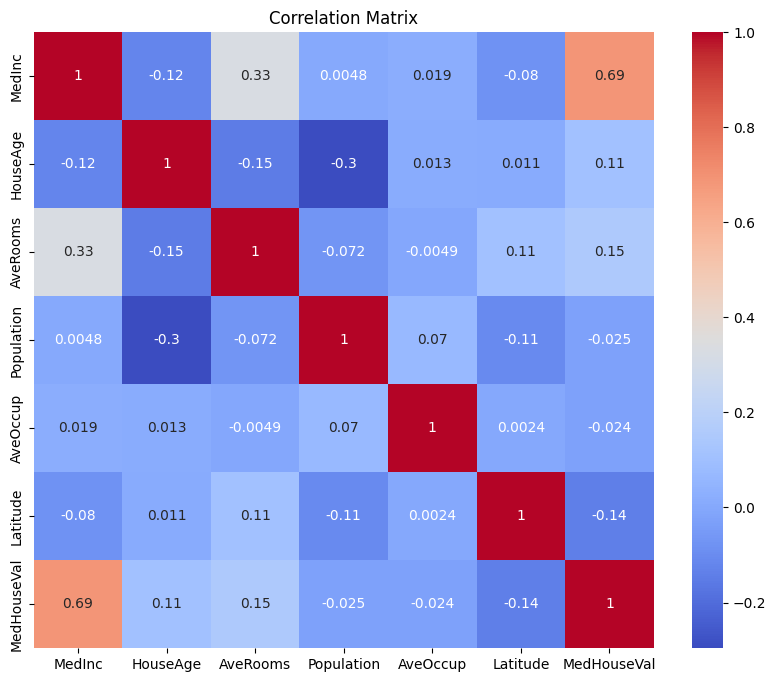

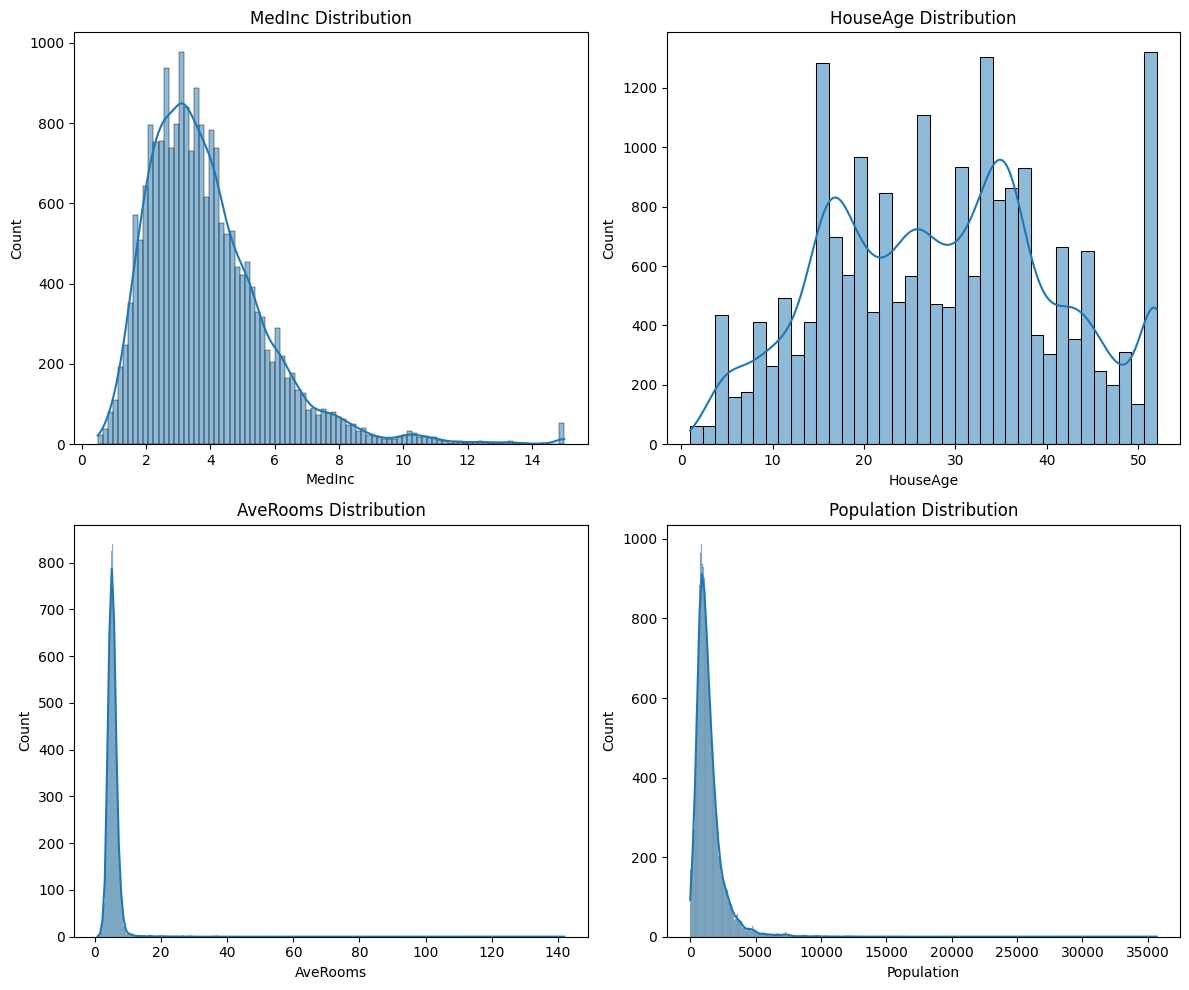

In [116]:
# Step 11: Display and visualize data after removing highly correlated features
features_to_visualize = [
    feature
    for feature in processor.initial_features
    if feature not in processor.dropped_features and feature != "MedHouseVal"
]


DataVisualizer.display_dataframe(data_clean)
DataVisualizer.visualize_correlations(data_clean)
DataVisualizer.visualize_distributions(data_clean, features_to_visualize)

In [117]:
# Step 12: Split the data
X_train, X_test, y_train, y_test = processor.split_data(target="MedHouseVal")

In [118]:
# Step 13: Define pipelines for different models, including Polynomial Regression
pipelines = {
    "LinearRegression": Pipeline(
        [("scaler", StandardScaler()), ("regressor", LinearRegression())]
    ),
    "PolynomialRegression": Pipeline(
        [
            ("poly_features", PolynomialFeatures()),
            ("scaler", StandardScaler()),
            ("regressor", LinearRegression()),
        ]
    ),
}

In [119]:
# Step 14: Define hyperparameters for different models
param_grids = {
    "LinearRegression": {"regressor__fit_intercept": [True, False]},
    "PolynomialRegression": {
        "poly_features__degree": [2, 3, 4],
        "regressor__fit_intercept": [True, False],
    },
}

In [120]:
# Step 15: Train and evaluate different models
results = {}
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    manager = ModelManager(pipeline, param_grid)
    trained_pipeline = manager.train(X_train, y_train)
    r2, mae, mape = manager.evaluate(X_test, y_test)
    best_params = manager.get_best_params()
    results[model_name] = {
        "R2": r2,
        "MAE": mae,
        "MAPE": mape,
        "Best Params": best_params,
    }

In [121]:
# Display results for different models
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    ResultDisplay.display_metrics(metrics["R2"], metrics["MAE"], metrics["MAPE"])
    print(f"Best Parameters: {metrics['Best Params']}")
    print("\n")

Model: LinearRegression


,R2,MAE,MAPE
0,0.50598,0.598271,0.36849


Best Parameters: {'regressor__fit_intercept': True}


Model: PolynomialRegression


,R2,MAE,MAPE
0,0.572027,0.542805,0.330055


Best Parameters: {'poly_features__degree': 2, 'regressor__fit_intercept': True}




In [122]:
# Step 16: Compare new metrics with previous model metrics and make conclusions
previous_r2, previous_mae, previous_mape = 0.69, 0.46, 0.27
comparison_results = []

for model_name, metrics in results.items():
    print(f"Comparison for model: {model_name}")
    ResultDisplay.compare_metrics(
        [previous_r2, previous_mae, previous_mape],
        [metrics["R2"], metrics["MAE"], metrics["MAPE"]],
    )
    comparison_results.append(
        (model_name, metrics["R2"], metrics["MAE"], metrics["MAPE"])
    )
    print("\n")

# Displaying the comparison results in a table
comparison_df = pd.DataFrame(comparison_results, columns=["Model", "R2", "MAE", "MAPE"])
display(comparison_df)

Comparison for model: LinearRegression


,Metric,Previous,New
0,R2,0.69,0.505980
1,MAE,0.46,0.598271
2,MAPE,0.27,0.368490


The new model did not improve performance.


Comparison for model: PolynomialRegression


,Metric,Previous,New
0,R2,0.69,0.572027
1,MAE,0.46,0.542805
2,MAPE,0.27,0.330055


The new model did not improve performance.




,Model,R2,MAE,MAPE
0,LinearRegression,0.505980,0.598271,0.368490
1,PolynomialRegression,0.572027,0.542805,0.330055
